# SHUBHAM SHARMA
## IIT BOMBAY
This code is a pytorch implimentation of the U-Net architecture that we have using **DICE LOSS AS LOSS FUNCTION**

In [1]:
#Importing the functions for U-net
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
# from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import cv2

In [2]:
#CHecking the number of GPU and then setting the GPU id
print(torch.cuda.current_device())#To know thw current active device
device = torch.device('cuda:1')
print(device)

0
cuda:1


In [3]:
num_of_classes=2
# input_size=(1, 128, 128, 128)
# input_size[1]*input_size[2]*input_size[3]

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        
        #For first layer input(_,320,320,128)
        self.conv1a=nn.Conv3d(in_channels=1, out_channels=32, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv1b=nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3,3,3), stride=1, padding=1)
        self.BN1=nn.BatchNorm3d(32)
        
        #For second layer (_,160,160,64)
        self.conv2a=nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv2b=nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3,3,3), stride=1, padding=1)
        self.BN2=nn.BatchNorm3d(64)
        
        #For third layer (80,80,32)
        self.conv3a=nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv3b=nn.Conv3d(in_channels=128, out_channels=128, kernel_size=(3,3,3), stride=1, padding=1)
        self.BN3=nn.BatchNorm3d(128)
        
        #For forth layer 
        self.conv4a=nn.Conv3d(in_channels=128, out_channels=256, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv4b=nn.Conv3d(in_channels=256, out_channels=256, kernel_size=(3,3,3), stride=1, padding=1)
        self.BN4=nn.BatchNorm3d(256)
        
        #For Upsampling/ seventh layer
        self.upconv1=nn.ConvTranspose3d(in_channels=256, out_channels=128, kernel_size=(2,2,2), stride=2, padding=0)
        self.conv5a=nn.Conv3d(in_channels=256, out_channels=128, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv5b=nn.Conv3d(in_channels=128, out_channels=128, kernel_size=(3,3,3), stride=1, padding=1)
        
        #For Upsampling/ eighth layer
        self.upconv2=nn.ConvTranspose3d(in_channels=128, out_channels=64, kernel_size=(2,2,2), stride=2, padding=0)
        self.conv6a=nn.Conv3d(in_channels=128, out_channels=64, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv6b=nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3,3,3), stride=1, padding=1)

        #For Upsampling/ ninth layer
        self.upconv3=nn.ConvTranspose3d(in_channels=64, out_channels=32, kernel_size=(2,2,2), stride=2, padding=0)
        self.conv7a=nn.Conv3d(in_channels=64, out_channels=32, kernel_size=(3,3,3), stride=1, padding=1)
        self.conv7b=nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3,3,3), stride=1, padding=1)
        
        #For last layer
        self.convLast=nn.Conv3d(in_channels=32, out_channels=num_of_classes, kernel_size=(3,3,3), stride=1, padding=1)
#         self.convLast=nn.Conv3d(in_channels=32, out_channels=2, kernel_size=(3,3,3), stride=1, padding=1)
        
        #For maxpool
        self.max_pool=nn.MaxPool3d(kernel_size=(2,2,2), stride=2)
        
        #For activation function
        self.relu = nn.ReLU()
        
    def forward(self,x):
        conv1 = self.conv1a(x)
        conv1 = self.relu(conv1)
        conv1 = self.BN1(conv1)
        conv1 = self.conv1b(conv1)
        conv1 = self.relu(conv1)
        conv1 = self.BN1(conv1)
        pool1 = self.max_pool(conv1)
        ##
        conv2 = self.conv2a(pool1)
        conv2 = self.relu(conv2)
        conv2 = self.BN2(conv2)
        conv2 = self.conv2b(conv2)
        conv2 = self.relu(conv2)
        conv2 = self.BN2(conv2)
        pool2 = self.max_pool(conv2)
        ##
        conv3 = self.conv3a(pool2)
        conv3 = self.relu(conv3)
        conv3 = self.BN3(conv3)
        conv3 = self.conv3b(conv3)
        conv3 = self.relu(conv3)
        conv3 = self.BN3(conv3)
        pool3 = self.max_pool(conv3)
        #
        conv4 = self.conv4a(pool3)
        conv4 = self.relu(conv4)
        conv4 = self.conv4b(conv4)
        conv4 = self.relu(conv4)
        ##
        up5 = torch.cat((self.upconv1(conv4),conv3),dim=1)
        conv5 = self.conv5a(up5)
        conv5 = self.conv5b(conv5)
        ##
        up6 = torch.cat((self.upconv2(conv5),conv2),dim=1)
        conv6 = self.conv6a(up6)
        conv6 = self.conv6b(conv6)
        ##
        up6 = torch.cat((self.upconv3(conv6),conv1),dim=1)
        conv7 = self.conv7a(up6)
        conv7 = self.conv7b(conv7)
        ##
        conv8 = self.convLast(conv7)
#         conv8 = F.softmax(conv8,1)
        return conv8
          
          
          
##########################################################################
model = Net().to(device)#not necessary to add to device
# summary(model, input_size=input_size)        
    
        
        

In [4]:
import torch
import torch.nn.functional as F
from torch import nn as nn
from torch.autograd import Variable
from torch.nn import MSELoss, SmoothL1Loss, L1Loss


def compute_per_channel_dice(input, target, epsilon=1e-5, ignore_index=None, weight=None):
    # assumes that input is a normalized probability

    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    # mask ignore_index if present
    if ignore_index is not None:
        mask = target.clone().ne_(ignore_index)
        mask.requires_grad = False

        input = input * mask
        target = target * mask

    input = flatten(input)
    target = flatten(target)

    target = target.float()
    # Compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    denominator = (input + target).sum(-1)
    return 2. * intersect / denominator.clamp(min=epsilon)


class DiceLoss(nn.Module):
    """Computes Dice Loss, which just 1 - DiceCoefficient described above.
    Additionally allows per-class weights to be provided.
    """

    def __init__(self, epsilon=1e-5, weight=None, ignore_index=None, sigmoid_normalization=True,
                 skip_last_target=False):
        super(DiceLoss, self).__init__()
        self.epsilon = epsilon
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index
        # The output from the network during training is assumed to be un-normalized probabilities and we would
        # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
        # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
        # However if one would like to apply Softmax in order to get the proper probability distribution from the
        # output, just specify sigmoid_normalization=False.
        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = nn.Softmax(dim=1)
        # if True skip the last channel in the target
        self.skip_last_target = skip_last_target

    def forward(self, input, target):
        # get probabilities from logits
        input = self.normalization(input)
        if self.weight is not None:
            weight = Variable(self.weight, requires_grad=False)
        else:
            weight = None

        if self.skip_last_target:
            target = target[:, :-1, ...]

        per_channel_dice = compute_per_channel_dice(input, target, epsilon=self.epsilon, ignore_index=self.ignore_index,
                                                    weight=weight)
        # Average the Dice score across all channels/classes
        return torch.mean(1. - per_channel_dice)


class GeneralizedDiceLoss(nn.Module):
    """Computes Generalized Dice Loss (GDL) as described in https://arxiv.org/pdf/1707.03237.pdf
    """

    def __init__(self, epsilon=1e-5, weight=None, ignore_index=None, sigmoid_normalization=True):
        super(GeneralizedDiceLoss, self).__init__()
        self.epsilon = epsilon
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index
        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = nn.Softmax(dim=1)

    def forward(self, input, target):
        # get probabilities from logits
        input = self.normalization(input)

        assert input.size() == target.size(), "'input' and 'target' must have the same shape"

        # mask ignore_index if present
        if self.ignore_index is not None:
            mask = target.clone().ne_(self.ignore_index)
            mask.requires_grad = False

            input = input * mask
            target = target * mask

        input = flatten(input)
        target = flatten(target)

        target = target.float()
        target_sum = target.sum(-1)
        class_weights = Variable(1. / (target_sum * target_sum).clamp(min=self.epsilon), requires_grad=False)

        intersect = (input * target).sum(-1) * class_weights
        if self.weight is not None:
            weight = Variable(self.weight, requires_grad=False)
            intersect = weight * intersect
        intersect = intersect.sum()

        denominator = ((input + target).sum(-1) * class_weights).sum()

        return 1. - 2. * intersect / denominator.clamp(min=self.epsilon)


class WeightedCrossEntropyLoss(nn.Module):
    """WeightedCrossEntropyLoss (WCE) as described in https://arxiv.org/pdf/1707.03237.pdf
    """

    def __init__(self, weight=None, ignore_index=-1):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index

    def forward(self, input, target):
        class_weights = self._class_weights(input)
        if self.weight is not None:
            weight = Variable(self.weight, requires_grad=False)
            class_weights = class_weights * weight
        return F.cross_entropy(input, target, weight=class_weights, ignore_index=self.ignore_index)

    @staticmethod
    def _class_weights(input):
        # normalize the input first
        input = F.softmax(input, _stacklevel=5)
        flattened = flatten(input)
        nominator = (1. - flattened).sum(-1)
        denominator = flattened.sum(-1)
        class_weights = Variable(nominator / denominator, requires_grad=False)
        return class_weights


class BCELossWrapper:
    """
    Wrapper around BCE loss functions allowing to pass 'ignore_index' as well as 'skip_last_target' option.
    """

    def __init__(self, loss_criterion, ignore_index=-1, skip_last_target=False):
        if hasattr(loss_criterion, 'ignore_index'):
            raise RuntimeError(f"Cannot wrap {type(loss_criterion)}. Use 'ignore_index' attribute instead")
        self.loss_criterion = loss_criterion
        self.ignore_index = ignore_index
        self.skip_last_target = skip_last_target

    def __call__(self, input, target):
        if self.skip_last_target:
            target = target[:, :-1, ...]

        assert input.size() == target.size()

        masked_input = input
        masked_target = target
        if self.ignore_index is not None:
            mask = target.clone().ne_(self.ignore_index)
            mask.requires_grad = False

            masked_input = input * mask
            masked_target = target * mask

        return self.loss_criterion(masked_input, masked_target)


class PixelWiseCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights=None, ignore_index=None):
        super(PixelWiseCrossEntropyLoss, self).__init__()
        self.register_buffer('class_weights', class_weights)
        self.ignore_index = ignore_index
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, target, weights):
        assert target.size() == weights.size()
        # normalize the input
        log_probabilities = self.log_softmax(input)
        # standard CrossEntropyLoss requires the target to be (NxDxHxW), so we need to expand it to (NxCxDxHxW)
        target = expand_as_one_hot(target, C=input.size()[1], ignore_index=self.ignore_index)
        # expand weights
        weights = weights.unsqueeze(0)
        weights = weights.expand_as(input)

        # mask ignore_index if present
        if self.ignore_index is not None:
            mask = Variable(target.data.ne(self.ignore_index).float(), requires_grad=False)
            log_probabilities = log_probabilities * mask
            target = target * mask

        # create default class_weights if None
        if self.class_weights is None:
            class_weights = torch.ones(input.size()[1]).float().to(input.device)
            self.register_buffer('class_weights', class_weights)

        # resize class_weights to be broadcastable into the weights
        class_weights = self.class_weights.view(1, -1, 1, 1, 1)

        # multiply weights tensor by class weights
        weights = class_weights * weights

        # compute the losses
        result = -weights * target * log_probabilities
        # average the losses
        return result.mean()


class MSEWithLogitsLoss(MSELoss):
    """
    This loss combines a `Sigmoid` layer and the `MSELoss` in one single class.
    """

    def __init__(self):
        super(MSEWithLogitsLoss, self).__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input, target):
        return super().forward(self.sigmoid(input), target)


class TagsAngularLoss(nn.Module):
    def __init__(self, tags_coefficients):
        super(TagsAngularLoss, self).__init__()
        self.tags_coefficients = tags_coefficients

    def forward(self, inputs, targets, weight):
        assert isinstance(inputs, list)
        # if there is just one output head the 'inputs' is going to be a singleton list [tensor]
        # and 'targets' is just going to be a tensor (that's how the HDF5Dataloader works)
        # so wrap targets in a list in this case
        if len(inputs) == 1:
            targets = [targets]
        assert len(inputs) == len(targets) == len(self.tags_coefficients)
        loss = 0
        for input, target, alpha in zip(inputs, targets, self.tags_coefficients):
            loss += alpha * square_angular_loss(input, target, weight)

        return loss


def square_angular_loss(input, target, weights=None):
    """
    Computes square angular loss between input and target directions.
    Makes sure that the input and target directions are normalized so that torch.acos would not produce NaNs.
    :param input: 5D input tensor (NCDHW)
    :param target: 5D target tensor (NCDHW)
    :param weights: 3D weight tensor in order to balance different instance sizes
    :return: per pixel weighted sum of squared angular losses
    """
    assert input.size() == target.size()
    # normalize and multiply by the stability_coeff in order to prevent NaN results from torch.acos
    stability_coeff = 0.999999
    input = input / torch.norm(input, p=2, dim=1).detach().clamp(min=1e-8) * stability_coeff
    target = target / torch.norm(target, p=2, dim=1).detach().clamp(min=1e-8) * stability_coeff
    # compute cosine map
    cosines = (input * target).sum(dim=1)
    error_radians = torch.acos(cosines)
    if weights is not None:
        return (error_radians * error_radians * weights).sum()
    else:
        return (error_radians * error_radians).sum()


def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.contiguous().view(C, -1)


def expand_as_one_hot(input, C, ignore_index=None):
    """
    Converts NxDxHxW label image to NxCxDxHxW, where each label gets converted to its corresponding one-hot vector
    :param input: 4D input image (NxDxHxW)
    :param C: number of channels/labels
    :param ignore_index: ignore index to be kept during the expansion
    :return: 5D output image (NxCxDxHxW)
    """
    assert input.dim() == 4

    shape = input.size()
    shape = list(shape)
    shape.insert(1, C)
    shape = tuple(shape)

    # expand the input tensor to Nx1xDxHxW
    src = input.unsqueeze(0)

    if ignore_index is not None:
        # create ignore_index mask for the result
        expanded_src = src.expand(shape)
        mask = expanded_src == ignore_index
        # clone the src tensor and zero out ignore_index in the input
        src = src.clone()
        src[src == ignore_index] = 0
        # scatter to get the one-hot tensor
        result = torch.zeros(shape).to(input.device).scatter_(1, src, 1)
        # bring back the ignore_index in the result
        result[mask] = ignore_index
        return result
    else:
        # scatter to get the one-hot tensor
        return torch.zeros(shape).to(input.device).scatter_(1, src, 1)


SUPPORTED_LOSSES = ['BCEWithLogitsLoss', 'CrossEntropyLoss', 'WeightedCrossEntropyLoss', 'PixelWiseCrossEntropyLoss',
                    'GeneralizedDiceLoss', 'DiceLoss', 'TagsAngularLoss', 'MSEWithLogitsLoss', 'MSELoss',
                    'SmoothL1Loss', 'L1Loss']


def get_loss_criterion(config):
    """
    Returns the loss function based on provided configuration
    :param config: (dict) a top level configuration object containing the 'loss' key
    :return: an instance of the loss function
    """
    assert 'loss' in config, 'Could not find loss function configuration'
    loss_config = config['loss']
    name = loss_config['name']

    ignore_index = loss_config.get('ignore_index', None)
    weight = loss_config.get('weight', None)

    if weight is not None:
        # convert to cuda tensor if necessary
        weight = torch.tensor(weight).to(config['device'])

    if name == 'BCEWithLogitsLoss':
        skip_last_target = loss_config.get('skip_last_target', False)
        if ignore_index is None and not skip_last_target:
            return nn.BCEWithLogitsLoss()
        else:
            return BCELossWrapper(nn.BCEWithLogitsLoss(), ignore_index=ignore_index, skip_last_target=skip_last_target)
    elif name == 'CrossEntropyLoss':
        if ignore_index is None:
            ignore_index = -100  # use the default 'ignore_index' as defined in the CrossEntropyLoss
        return nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)
    elif name == 'WeightedCrossEntropyLoss':
        if ignore_index is None:
            ignore_index = -100  # use the default 'ignore_index' as defined in the CrossEntropyLoss
        return WeightedCrossEntropyLoss(weight=weight, ignore_index=ignore_index)
    elif name == 'PixelWiseCrossEntropyLoss':
        return PixelWiseCrossEntropyLoss(class_weights=weight, ignore_index=ignore_index)
    elif name == 'GeneralizedDiceLoss':
        return GeneralizedDiceLoss(weight=weight, ignore_index=ignore_index)
    elif name == 'DiceLoss':
        sigmoid_normalization = loss_config.get('sigmoid_normalization', True)
        skip_last_target = loss_config.get('skip_last_target', False)
        return DiceLoss(weight=weight, ignore_index=ignore_index, sigmoid_normalization=sigmoid_normalization,
                        skip_last_target=skip_last_target)
    elif name == 'TagsAngularLoss':
        tags_coefficients = loss_config['tags_coefficients']
        return TagsAngularLoss(tags_coefficients)
    elif name == 'MSEWithLogitsLoss':
        return MSEWithLogitsLoss()
    elif name == 'MSELoss':
        return MSELoss()
    elif name == 'SmoothL1Loss':
        return SmoothL1Loss()
    elif name == 'L1Loss':
        return L1Loss()
    else:
        raise RuntimeError(f"Unsupported loss function: '{name}'. Supported losses: {SUPPORTED_LOSSES}")

In [5]:
#Loading the dataset
X=np.load('./X_cardiac_downed.npy')
X=X.reshape(X.shape[0],1,X.shape[1],X.shape[2],X.shape[3])
X_whitened = np.zeros(X.shape)
for i in range(X.shape[0]):
    temp1=X[i]
    temp2=(temp1 - np.mean(temp1))/(np.std(temp1))
    X_whitened[i]=temp2
Y=np.load('./Y_cardiac_categorical_downed.npy')
# Y = np.reshape(Y[:,1,:,:,:],(20,1,128,128,128))
# Y=np.load('./Y_cardiac_downed.npy')
# Y = np.reshape(Y,(20,1,128,128,128))
print(Y.shape)
###################################################
#Function to create label array for binary classification
# def binarylab(labels):
#     length,width,height,classes = 128,128,128,2
#     #Define an Empty Array 
#     x = np.zeros([length,width,height,classes],dtype="uint8")
#     #Read Each pixel label and put it into corresponding label plane
#     for i in range(length):
#         for j in range(width):
#             for k in range(height): 
#                 x[i,j,k,labels[i][j][k]]=1
#     return x

# Y=np.load('./Y_cardiac_downed.npy')
# length,width,height,classes = 128,128,128,2
# c=0
# for i in range(Y.shape[0]):
#     temp1 = binarylab(Y[i])
#     temp2 = np.reshape(temp1,(1,length,width,height,classes))
#     if c==0:
#         Y_categorical=temp2
#     else:
#         Y_categorical=np.concatenate((Y_categorical, temp2), axis=0)
#     c+=1
#     print(c)
# print(Y_categorical.shape)

(20, 2, 128, 128, 128)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(X_whitened, Y, test_size=0.20)
print('The shape of x_train_cardiac is :',x_train.shape)
print('The shape of x_test_cardiac is :',x_test.shape)
print('The shape of y_train_cardiac is :',y_train.shape)
print('The shape of y_test_cardiac is :',y_test.shape)
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

The shape of x_train_cardiac is : (16, 1, 128, 128, 128)
The shape of x_test_cardiac is : (4, 1, 128, 128, 128)
The shape of y_train_cardiac is : (16, 2, 128, 128, 128)
The shape of y_test_cardiac is : (4, 2, 128, 128, 128)


In [7]:
trainset = torch.utils.data.TensorDataset(x_train,y_train)# create your datset
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 2, shuffle = True)

valset = torch.utils.data.TensorDataset(x_test,y_test)# create your datset
valloader = torch.utils.data.DataLoader(valset, batch_size = 1, shuffle = True)

In [8]:
# # learning rate and number of  epochs
# num_of_epochs = 1
# lr=1e-4

# # Loss and optimizer
# # loss_fn = nn.CrossEntropyLoss()#NO NEED TO BE USING SOFTMAX WHEN USING Crioss Entropy loss
# loss_fn = GeneralizedDiceLoss(sigmoid_normalization=False)
# optimizer = optim.Adam(model.parameters(), lr=lr) 

In [10]:
# learning rate and number of  epochs
num_of_epochs = 800
lr=1e-7

# Loss and optimizer
# loss_fn = nn.CrossEntropyLoss()#NO NEED TO BE USING SOFTMAX WHEN USING Crioss Entropy loss
loss_fn = DiceLoss(sigmoid_normalization=False)
optimizer = optim.Adam(model.parameters(), lr=lr) 

#Training the model
total_step = len(trainloader)
for epochs in range(num_of_epochs):
    for i, (images, labels) in enumerate(trainloader):  
            #CHECK THE SHAPE OF BOTH IMAGES AND LABELS
            images = images.to(device)
            images= images.float()
            labels = labels.to(device)  

            #Forward pass
            outputs = model(images)
#             print(outputs.shape,labels.shape)
#             labels = labels.long()
            loss = loss_fn(outputs, labels)
            
            # Backpropagation and then optimization
            optimizer.zero_grad()#Initially setting the gradient values to zero so backward() can find the gradient
            loss.backward()#backpropagate and then optimize
            optimizer.step()
        #     if (i+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epochs+1, num_of_epochs, i+1, total_step, loss.item()))
    torch.save(model, './cardiac_dice_loss')

    
    
    

Epoch [1/800], Step [1/8], Loss: 0.0559
Epoch [1/800], Step [2/8], Loss: 0.0586
Epoch [1/800], Step [3/8], Loss: 0.0532
Epoch [1/800], Step [4/8], Loss: 0.0552
Epoch [1/800], Step [5/8], Loss: 0.0583
Epoch [1/800], Step [6/8], Loss: 0.0519
Epoch [1/800], Step [7/8], Loss: 0.0637
Epoch [1/800], Step [8/8], Loss: 0.0585


/opt/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch [2/800], Step [1/8], Loss: 0.0594
Epoch [2/800], Step [2/8], Loss: 0.0598
Epoch [2/800], Step [3/8], Loss: 0.0567
Epoch [2/800], Step [4/8], Loss: 0.0511
Epoch [2/800], Step [5/8], Loss: 0.0556
Epoch [2/800], Step [6/8], Loss: 0.0456
Epoch [2/800], Step [7/8], Loss: 0.0585
Epoch [2/800], Step [8/8], Loss: 0.0651
Epoch [3/800], Step [1/8], Loss: 0.0486
Epoch [3/800], Step [2/8], Loss: 0.0584
Epoch [3/800], Step [3/8], Loss: 0.0588
Epoch [3/800], Step [4/8], Loss: 0.0589
Epoch [3/800], Step [5/8], Loss: 0.0551
Epoch [3/800], Step [6/8], Loss: 0.0556
Epoch [3/800], Step [7/8], Loss: 0.0540
Epoch [3/800], Step [8/8], Loss: 0.0632
Epoch [4/800], Step [1/8], Loss: 0.0532
Epoch [4/800], Step [2/8], Loss: 0.0576
Epoch [4/800], Step [3/8], Loss: 0.0640
Epoch [4/800], Step [4/8], Loss: 0.0588
Epoch [4/800], Step [5/8], Loss: 0.0556
Epoch [4/800], Step [6/8], Loss: 0.0549
Epoch [4/800], Step [7/8], Loss: 0.0583
Epoch [4/800], Step [8/8], Loss: 0.0482
Epoch [5/800], Step [1/8], Loss: 0.0610


Epoch [27/800], Step [3/8], Loss: 0.0486
Epoch [27/800], Step [4/8], Loss: 0.0540
Epoch [27/800], Step [5/8], Loss: 0.0571
Epoch [27/800], Step [6/8], Loss: 0.0551
Epoch [27/800], Step [7/8], Loss: 0.0672
Epoch [27/800], Step [8/8], Loss: 0.0591
Epoch [28/800], Step [1/8], Loss: 0.0551
Epoch [28/800], Step [2/8], Loss: 0.0572
Epoch [28/800], Step [3/8], Loss: 0.0545
Epoch [28/800], Step [4/8], Loss: 0.0541
Epoch [28/800], Step [5/8], Loss: 0.0542
Epoch [28/800], Step [6/8], Loss: 0.0567
Epoch [28/800], Step [7/8], Loss: 0.0504
Epoch [28/800], Step [8/8], Loss: 0.0667
Epoch [29/800], Step [1/8], Loss: 0.0478
Epoch [29/800], Step [2/8], Loss: 0.0544
Epoch [29/800], Step [3/8], Loss: 0.0672
Epoch [29/800], Step [4/8], Loss: 0.0508
Epoch [29/800], Step [5/8], Loss: 0.0583
Epoch [29/800], Step [6/8], Loss: 0.0590
Epoch [29/800], Step [7/8], Loss: 0.0597
Epoch [29/800], Step [8/8], Loss: 0.0535
Epoch [30/800], Step [1/8], Loss: 0.0570
Epoch [30/800], Step [2/8], Loss: 0.0583
Epoch [30/800], 

Epoch [52/800], Step [3/8], Loss: 0.0541
Epoch [52/800], Step [4/8], Loss: 0.0560
Epoch [52/800], Step [5/8], Loss: 0.0641
Epoch [52/800], Step [6/8], Loss: 0.0589
Epoch [52/800], Step [7/8], Loss: 0.0457
Epoch [52/800], Step [8/8], Loss: 0.0588
Epoch [53/800], Step [1/8], Loss: 0.0602
Epoch [53/800], Step [2/8], Loss: 0.0585
Epoch [53/800], Step [3/8], Loss: 0.0542
Epoch [53/800], Step [4/8], Loss: 0.0532
Epoch [53/800], Step [5/8], Loss: 0.0559
Epoch [53/800], Step [6/8], Loss: 0.0670
Epoch [53/800], Step [7/8], Loss: 0.0462
Epoch [53/800], Step [8/8], Loss: 0.0550
Epoch [54/800], Step [1/8], Loss: 0.0502
Epoch [54/800], Step [2/8], Loss: 0.0547
Epoch [54/800], Step [3/8], Loss: 0.0543
Epoch [54/800], Step [4/8], Loss: 0.0560
Epoch [54/800], Step [5/8], Loss: 0.0564
Epoch [54/800], Step [6/8], Loss: 0.0562
Epoch [54/800], Step [7/8], Loss: 0.0583
Epoch [54/800], Step [8/8], Loss: 0.0615
Epoch [55/800], Step [1/8], Loss: 0.0533
Epoch [55/800], Step [2/8], Loss: 0.0584
Epoch [55/800], 

Epoch [77/800], Step [3/8], Loss: 0.0550
Epoch [77/800], Step [4/8], Loss: 0.0510
Epoch [77/800], Step [5/8], Loss: 0.0639
Epoch [77/800], Step [6/8], Loss: 0.0503
Epoch [77/800], Step [7/8], Loss: 0.0536
Epoch [77/800], Step [8/8], Loss: 0.0539
Epoch [78/800], Step [1/8], Loss: 0.0478
Epoch [78/800], Step [2/8], Loss: 0.0550
Epoch [78/800], Step [3/8], Loss: 0.0575
Epoch [78/800], Step [4/8], Loss: 0.0520
Epoch [78/800], Step [5/8], Loss: 0.0654
Epoch [78/800], Step [6/8], Loss: 0.0592
Epoch [78/800], Step [7/8], Loss: 0.0539
Epoch [78/800], Step [8/8], Loss: 0.0555
Epoch [79/800], Step [1/8], Loss: 0.0637
Epoch [79/800], Step [2/8], Loss: 0.0570
Epoch [79/800], Step [3/8], Loss: 0.0558
Epoch [79/800], Step [4/8], Loss: 0.0581
Epoch [79/800], Step [5/8], Loss: 0.0471
Epoch [79/800], Step [6/8], Loss: 0.0536
Epoch [79/800], Step [7/8], Loss: 0.0529
Epoch [79/800], Step [8/8], Loss: 0.0558
Epoch [80/800], Step [1/8], Loss: 0.0595
Epoch [80/800], Step [2/8], Loss: 0.0467
Epoch [80/800], 

Epoch [102/800], Step [3/8], Loss: 0.0539
Epoch [102/800], Step [4/8], Loss: 0.0548
Epoch [102/800], Step [5/8], Loss: 0.0585
Epoch [102/800], Step [6/8], Loss: 0.0541
Epoch [102/800], Step [7/8], Loss: 0.0658
Epoch [102/800], Step [8/8], Loss: 0.0458
Epoch [103/800], Step [1/8], Loss: 0.0567
Epoch [103/800], Step [2/8], Loss: 0.0614
Epoch [103/800], Step [3/8], Loss: 0.0535
Epoch [103/800], Step [4/8], Loss: 0.0580
Epoch [103/800], Step [5/8], Loss: 0.0465
Epoch [103/800], Step [6/8], Loss: 0.0577
Epoch [103/800], Step [7/8], Loss: 0.0544
Epoch [103/800], Step [8/8], Loss: 0.0563
Epoch [104/800], Step [1/8], Loss: 0.0641
Epoch [104/800], Step [2/8], Loss: 0.0438
Epoch [104/800], Step [3/8], Loss: 0.0583
Epoch [104/800], Step [4/8], Loss: 0.0590
Epoch [104/800], Step [5/8], Loss: 0.0549
Epoch [104/800], Step [6/8], Loss: 0.0534
Epoch [104/800], Step [7/8], Loss: 0.0546
Epoch [104/800], Step [8/8], Loss: 0.0528
Epoch [105/800], Step [1/8], Loss: 0.0599
Epoch [105/800], Step [2/8], Loss:

Epoch [126/800], Step [7/8], Loss: 0.0575
Epoch [126/800], Step [8/8], Loss: 0.0537
Epoch [127/800], Step [1/8], Loss: 0.0509
Epoch [127/800], Step [2/8], Loss: 0.0612
Epoch [127/800], Step [3/8], Loss: 0.0579
Epoch [127/800], Step [4/8], Loss: 0.0469
Epoch [127/800], Step [5/8], Loss: 0.0537
Epoch [127/800], Step [6/8], Loss: 0.0546
Epoch [127/800], Step [7/8], Loss: 0.0574
Epoch [127/800], Step [8/8], Loss: 0.0582
Epoch [128/800], Step [1/8], Loss: 0.0563
Epoch [128/800], Step [2/8], Loss: 0.0469
Epoch [128/800], Step [3/8], Loss: 0.0526
Epoch [128/800], Step [4/8], Loss: 0.0553
Epoch [128/800], Step [5/8], Loss: 0.0533
Epoch [128/800], Step [6/8], Loss: 0.0504
Epoch [128/800], Step [7/8], Loss: 0.0588
Epoch [128/800], Step [8/8], Loss: 0.0636
Epoch [129/800], Step [1/8], Loss: 0.0470
Epoch [129/800], Step [2/8], Loss: 0.0504
Epoch [129/800], Step [3/8], Loss: 0.0655
Epoch [129/800], Step [4/8], Loss: 0.0553
Epoch [129/800], Step [5/8], Loss: 0.0575
Epoch [129/800], Step [6/8], Loss:

Epoch [151/800], Step [3/8], Loss: 0.0530
Epoch [151/800], Step [4/8], Loss: 0.0573
Epoch [151/800], Step [5/8], Loss: 0.0583
Epoch [151/800], Step [6/8], Loss: 0.0539
Epoch [151/800], Step [7/8], Loss: 0.0497
Epoch [151/800], Step [8/8], Loss: 0.0628
Epoch [152/800], Step [1/8], Loss: 0.0535
Epoch [152/800], Step [2/8], Loss: 0.0545
Epoch [152/800], Step [3/8], Loss: 0.0534
Epoch [152/800], Step [4/8], Loss: 0.0550
Epoch [152/800], Step [5/8], Loss: 0.0627
Epoch [152/800], Step [6/8], Loss: 0.0457
Epoch [152/800], Step [7/8], Loss: 0.0588
Epoch [152/800], Step [8/8], Loss: 0.0590
Epoch [153/800], Step [1/8], Loss: 0.0574
Epoch [153/800], Step [2/8], Loss: 0.0553
Epoch [153/800], Step [3/8], Loss: 0.0582
Epoch [153/800], Step [4/8], Loss: 0.0552
Epoch [153/800], Step [5/8], Loss: 0.0637
Epoch [153/800], Step [6/8], Loss: 0.0534
Epoch [153/800], Step [7/8], Loss: 0.0465
Epoch [153/800], Step [8/8], Loss: 0.0525
Epoch [154/800], Step [1/8], Loss: 0.0581
Epoch [154/800], Step [2/8], Loss:

KeyboardInterrupt: 

In [11]:
def show_slices(slices):
# Function to display row of image slices
      fig, axes = plt.subplots(1, len(slices))
      for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")
        
saved = torch.load('./cardiac_dice_loss')

Text(0.5,0.98,'Center slices for original output')

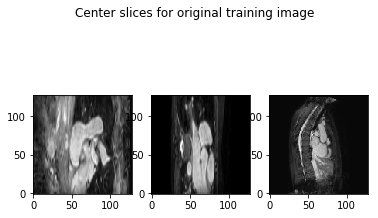

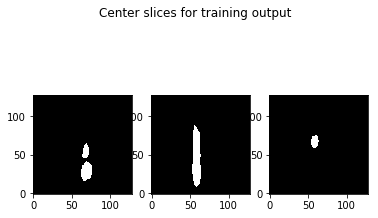

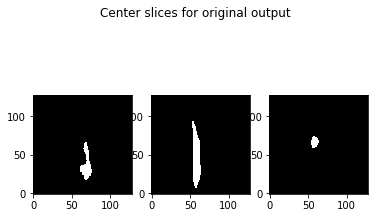

In [23]:
#Checking for train image
i=9
im = x_train[i].reshape(1,x_train[i].shape[0],x_train[i].shape[1],x_train[i].shape[2],x_train[i].shape[3])
n_im = x_train[i][0,:,:,:]
n_im = n_im.cpu()
n_im = n_im.detach().numpy()
slice_0 = n_im[64, :, :]
slice_1 = n_im[:, 64, :]
slice_2 = n_im[:, :, 64]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for original training image") 

# im = torch.from_numpy(im)
im = im.to(device)
im = im.float()
output = saved(im)
pred = F.softmax(output,1)
pred = pred[0,:,:,:]
pred = pred.cpu()
pred = pred.detach().numpy()
# print(pred.shape)
result = np.argmax(pred, axis = 0)
result = result.reshape(128, 128, 128)
slice_0 = result[64, :, :]
slice_1 = result[:, 64, :]
slice_2 = result[:, :, 64]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for training output")

ori = y_train[i][1]
ori = ori.cpu()
ori = ori.detach().numpy()
slice_0 = ori[64, :, :]
slice_1 = ori[:, 64, :]
slice_2 = ori[:, :, 64]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for original output")

Text(0.5,0.98,'Center slices for testing output')

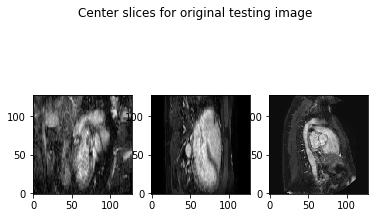

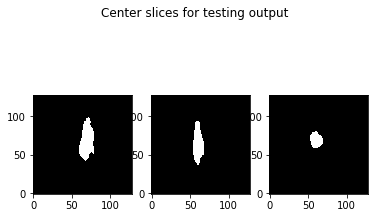

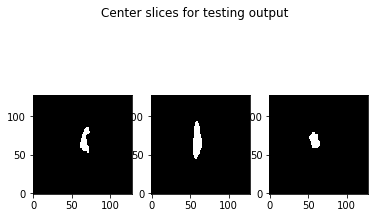

In [19]:
#Checking for train image
i=1
im = x_test[i].reshape(1,x_test[i].shape[0],x_test[i].shape[1],x_test[i].shape[2],x_test[i].shape[3])
n_im = x_test[i][0,:,:,:]
n_im = n_im.cpu()
n_im = n_im.detach().numpy()
slice_0 = n_im[64, :, :]
slice_1 = n_im[:, 64, :]
slice_2 = n_im[:, :, 64]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for original testing image") 

# im = torch.from_numpy(im)
im = im.to(device)
im = im.float()
output = saved(im)
pred = F.softmax(output,1)
pred = pred[0,:,:,:]
pred = pred.cpu()
pred = pred.detach().numpy()
# print(pred.shape)
result = np.argmax(pred, axis = 0)
result = result.reshape(128, 128, 128)
slice_0 = result[64, :, :]
slice_1 = result[:, 64, :]
slice_2 = result[:, :, 64]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for testing output")

ori = y_test[i][1]
ori = ori.cpu()
ori = ori.detach().numpy()
slice_0 = ori[64, :, :]
slice_1 = ori[:, 64, :]
slice_2 = ori[:, :, 64]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for testing output")